# Problem 6. Multilayer Perceptrons with PyTorch

- In this homework you will train (again) a multilayer perceptron

- But differently from what you did in `Problem 5`, since this time, you will let the `PyTorch` library do most of the complicated work for you

- The goal of this notebook is to make you get familiar with `PyTorch` and the its main concepts, that we will use repeatedly along the course.

- We will be training a multilayer perceptron on the `CIFAR-10` dataset, a popular dataset of images that is used in Computer-Vision (CV) research

- You will need to use a lot the documentation of `PyTorch` and look at examples for this notebook.

In [3]:
import torch, torchvision
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt 

In [4]:
if torch.cuda.is_available():
    # torch.set_default_device("cuda")
    device = torch.device("cuda:0")
    # device = torch.device("cpu")

## Problem 6A: Load the dataset

- `PyTorch` provides popular computer vision datasets that can be easily downloaded
- The following code will download the `CIFAR-10` dataset for us  
- Since it is computationally expensive to load the entire dataset into memory, we will use `PyTorch`'s dataloaders  before feeding batches of images to the neural network

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
testset = datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)

batch_size = 16
# You should use as many cores you have on your laptop
num_workers = 32

# Fill in the options for both data loaders. Warning: the training dataloader should shuffle the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
testloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Added validation set

In [6]:
def load_data(size, njobs):
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
    testset = datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)

    train_set, val_set = torch.utils.data.random_split(trainset, [.8, .2])

    # batch_size = ?
    # You should use as many cores you have on your laptop
    # num_workers = ?

    # Fill in the options for both data loaders. Warning: the training dataloader should shuffle the data
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = size, shuffle = True, num_workers = njobs, pin_memory = True)
    valid_loader = torch.utils.data.DataLoader(val_set, batch_size = size, shuffle = False, num_workers = njobs, pin_memory = True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size = size, shuffle = False, num_workers = njobs, pin_memory = True)

    return train_loader, valid_loader, test_loader

## Visualize the Images of CIFAR-10

* Once everything is properly loaded you should be able to visualize some of the samples of the CIFAR-10

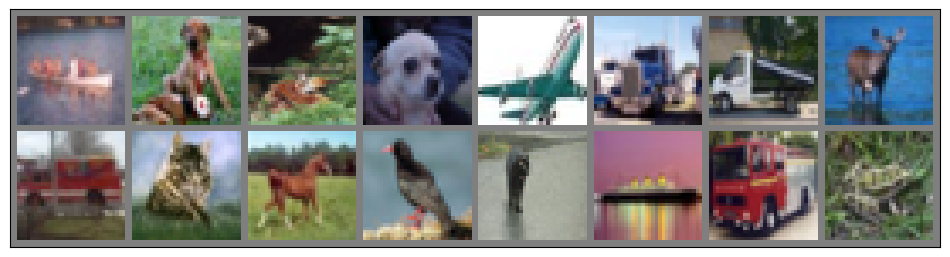

 ship   dog  deer   dog plane truck truck  deer truck   cat horse  bird   cat  ship truck  frog


In [7]:
def show_images(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Problem 6B. Creating an MLP model

- We are now ready to define all the necessary hyperparameters that are required to construct a proper MLP
- Similarly to what we did in `Problem 5` we need to explore the data carefully in order to know how to set the following parameters

### Hyperparameters

Choose suitable hyperparameters.

In [20]:
input_dim = 3 * 32 * 32; 
hidden_dim = [1024, 512, 256]; 
output_dim = len(classes); 
learning_rate = .0001; 
num_epochs = 200; 
batch_size = 128; 
njobs = 32; 
dropout = .5; 
optimizer_decay = 1e-4
stopper_args = {"threshold": 20, "epsilon": 1e-4}

### Define the Network

- You are free to define any kind of architecture that you think is reasonable for the problem of classifying CIFAR-10 images
- By default, you can use a multi-layer perceptron
- The constructor of the neural network will represent the different components of the computation-graph, note that it is very similar to the way we have programmed our own neural network in `Problem 5`.
- You will also have to define the forward pass yourself.

In [9]:
class Net(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list, output_dim: int, dropout_rate = 0.):
        super(Net, self).__init__()
        layers = [nn.Flatten()]
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

### Define the Earlystopper

In [10]:
class EarlyStopper:
    def __init__(self, threshold = float("inf"), epsilon = float("inf")):
        self.threshold = threshold
        self.epsilon = epsilon
        self.counter = 0
        self.min_valid_loss = float('inf')

    def early_stop(self, valid_loss):
        if valid_loss < self.min_valid_loss:
            self.min_valid_loss = valid_loss
            self.counter = 0
        elif valid_loss > (self.min_valid_loss + self.epsilon):
            self.counter += 1
            if self.counter >= self.threshold:
                return True
        return False

### This helper function is borrowed from Lab 5.

In [11]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item() 

## Problem 6C: Instantiate and Train the Network

- You are now ready to create your neural network object
- You will also have to define an appropriate loss function to minimize and an optimization algorithm
- By default, you can use the cross-entropy loss and the RMS prop optimizer

In [12]:
model = Net(input_dim, hidden_dim, output_dim, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = optimizer_decay)

### Train the Network

- Once you have your neural network you just need to train it. 
- You will have to compute the output of the forward pass, compare it to your desired output and update the parameters of the network by backpropagation. 
- Fortunately this time, this only requires less than 5 lines of code in `PyTorch`

In [13]:
def train(train_loader, valid_loader, model, criterion, optimizer, epochs, stopper_args):
    stopper = EarlyStopper(**stopper_args)
    for e in range(epochs):
        model.train()

        num_batches = len(train_loader)
        num_items = len(train_loader.dataset)

        total_loss = 0
        total_correct = 0
        
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)
            total_loss += loss

            total_correct += correct(output, target)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        training_loss = total_loss / num_batches
        accuracy_train = total_correct / num_items
        valid_loss, accuracy_valid = test(valid_loader, model, criterion, verbose = 0)
        if not (e+1) % 10:
            print("Epoch %d/%d: Training Loss %.6f\tValidation Loss %.6f\tTraining Accuracy %.2f%%\tValidation Accuracy %.2f%%" %(e+1, epochs, training_loss, valid_loss, accuracy_train*100, accuracy_valid*100))
        if stopper.early_stop(valid_loss):
            print("[Early stopping]\nEpoch %d/%d: Training Loss %.6f\tValidation Loss %.6f\tTraining Accuracy %.2f%%\tValidation Accuracy %.2f%%" %(e+1, epochs, training_loss, valid_loss, 
                                                                                                                                                    accuracy_train*100, accuracy_valid*100))
            break   

In [14]:
def test(test_loader, model, criterion, verbose = 1):
    '''
    test or validate
    '''
    model.eval()
    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)
            test_loss += loss

            total_correct += correct(output, target)
    test_loss /= num_batches
    accuracy = total_correct / num_items
    if not verbose:
        return test_loss, accuracy
    print("Test Loss %.6f\tTest Accuracy %.2f%%" %(test_loss, accuracy*100))

In [19]:
train_loader, valid_loader, test_loader = load_data(batch_size, njobs)
train(train_loader, valid_loader, model, criterion, optimizer, num_epochs, stopper_args)

Files already downloaded and verified
Files already downloaded and verified
Epoch 10/200: Training Loss 0.723862	Validation Loss 0.639772	Training Accuracy 75.01%	Validation Accuracy 79.04%
Epoch 20/200: Training Loss 0.643820	Validation Loss 0.674192	Training Accuracy 77.31%	Validation Accuracy 77.16%
[Early stopping]
Epoch 21/200: Training Loss 0.642872	Validation Loss 0.673547	Training Accuracy 77.52%	Validation Accuracy 76.80%


- Of course, repeated calls to `train` will continue training from where it were
- Training a neural network is a highly iterative process.

## Problem 6D: Evaluate the final performance of the Network

- Once you think your network is properly trained, you will test its performance on the testing-set of the CIFAR-10 dataset
- Compute the final accuracy of your model
- You should be able to reach a 50% accuracy with a simple multi-layer perceptron

In [18]:
test(test_loader, model, criterion)

Test Loss 1.272689	Test Accuracy 57.79%


**Final remark.** Of course, this is far from being the state-of-the-art. Indeed, convolutional neural nets are the backbones for computer vision problems (we will do it in following labs), while we only used here a feed-forward network.

## Bonus: Redo it using `pytorch-lightning`

There is some boilerplates in pure `PyTorch` code. The `pytorch-lighting` library is a new library allowing to simplify a lot the use of `PyTorch` together with very nice options for faster training and development.

**QUESTION**. Recode your neural network and its training using `pytorch-lightning`.